1.

Both the parasite and dye images are represented using a modified Run-Length Encoding (RLE) NumPy array of size uint32. The first element of this array represents the first pixel value, and the subsequent elements contain counts of 0s or 1s. Since this is a binary image, we only need to store the starting pixel value because the next pixel value will be either 0 or 1, depending on the starting value. For example, if the RLE array is 0, 1, 3 for a 2x2 resolution image, it means there is one 0 and three 1s, resulting in the original image [[0, 1], [1, 1]]. Since the actual images are of 100,000x100,000 resolution, we will have high counts of 0s and 1s in the RLE image, which is why uint32 size was chosen.

During my research, I realized that I needed to find an effective lossless compression technique. The compression must be lossless because ultimately we need to accurately determine whether the parasites have cancer or not. Losing any information during compression could lead to mislabeling the parasites. I explored both RLE and Huffman coding techniques and opted for RLE for the following reasons:

RLE is particularly effective in this situation because we have long sequences of consecutive identical pixels, representing either the continuous parasite body or the surrounding image.

RLE appeared to offer a better compression percentage compared to Huffman coding.

Huffman coding is a more complex approach

The worst-case storage size occurs when there are alternating 0s and 1s with run lengths equal to 1. In this case, there will be 100,000 * 100,000 + 1 elements in the list, including the starting pixel value. Since each element of this list is of type uint32, they will occupy 4 bytes each. The total size would be 4 * (100,000 * 100,000 + 1) bytes = 40 GB.

The parasite and dye pixels are represented with white pixels and the surrounding is reprented using black pixels

2.

The ImageProcessor class is designed to generate, manipulate, and store images in a compact and efficient manner. It provides methods to create two types of images: a parasite image and a dye image. The parasite image is generated by specifying a percentage range of black pixels within the image, and it uses a flood-fill algorithm to create contiguous regions of black pixels. The dye image is overlaid on the parasite image, covering a specified percentage of the parasite area.

The class also offers methods to display the generated images and to perform Run-Length Encoding (RLE) compression and decompression. In RLE encoding, it stores the counts of consecutive pixels of the same color and the starting element. RLE decoding uses this count and starting element to reconstruct the original image.

A novel feature is the efficient storage representation of images using RLE encoding, significantly reducing storage requirements compared to a simple bitmap representation. The class calculates the storage size of the images both in raw format and with RLE encoding, making it suitable for evaluating compression effectiveness.

In [69]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import time

class ImageProcessor:
    def __init__(self, image_size, dtype=np.uint8):
        self.image_size = image_size
        self.parasite_image = np.zeros(image_size, dtype=np.uint8)
        self.dye_image = np.zeros(image_size, dtype=np.uint8)
        self.dtype = dtype

    def create_parasite_and_dye_images(self):
        # Calculate the area for the parasite based on the given percentage range
        min_percentage = 0.25
        max_percentage = 1
        total_area = self.image_size[0] * self.image_size[1]
        min_parasite_area = int(min_percentage * total_area)
        max_parasite_area = int(max_percentage * total_area)

        # Randomly generate the area for the parasite within the specified range
        parasite_area = random.randint(min_parasite_area, max_parasite_area)

        # Initialize a stack for the flood-fill algorithm for the parasite image
        parasite_stack = []

        # Initialize a set to keep track of visited positions for the parasite image
        parasite_visited = set()

        num_black_pixels_parasite = 0  # Keep track of the number of black pixels in the parasite image

        while num_black_pixels_parasite < parasite_area:
            # Randomly generate the initial position for a black pixel
            x, y = random.randint(0, self.image_size[0] - 1), random.randint(0, self.image_size[1] - 1)

            # If the position has already been visited, skip it
            if (x, y) in parasite_visited:
                continue

            # Otherwise, mark it as visited and set it as the starting point for the parasite image
            parasite_visited.add((x, y))
            parasite_stack.append((x, y))

            # Set the pixel in the parasite image to black
            self.parasite_image[x, y] = 1
            num_black_pixels_parasite += 1

            # Define directions for 4-connectivity
            directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

            # Perform flood-fill to generate the remaining black pixels for the parasite image
            while num_black_pixels_parasite < parasite_area and parasite_stack:
                x, y = parasite_stack.pop()
                random.shuffle(directions)  # Randomize the order of directions

                for dx, dy in directions:
                    new_x, new_y = x + dx, y + dy

                    # Check if the new position is within the image boundaries for the parasite image
                    if (
                        0 <= new_x < self.image_size[0]
                        and 0 <= new_y < self.image_size[1]
                        and (new_x, new_y) not in parasite_visited
                    ):
                        parasite_visited.add((new_x, new_y))
                        self.parasite_image[new_x, new_y] = 1
                        parasite_stack.append((new_x, new_y))
                        num_black_pixels_parasite += 1

        # Store the positions of black pixels in the parasite image
        black_pixel_positions = [(x, y) for x in range(self.image_size[0]) for y in range(self.image_size[1]) if self.parasite_image[x, y] == 1]

        # Generate a random number between 1 and 100,000
        random_number = random.randint(1, 100000)

        # Determine whether to create a dye image that covers >= 10% or < 10% of the parasite area
        if random_number < 101:
            # Dye image covers >= 10% of the parasite area
            dye_coverage_percentage = random.uniform(10, 100)
        else:
            # Dye image covers < 10% of the parasite area
            dye_coverage_percentage = random.uniform(0, 9.9)

        # Calculate the number of black pixels for the dye image based on the coverage percentage
        dye_area = int((dye_coverage_percentage / 100) * parasite_area)

        # Randomly pick positions from the black_pixel_positions list to create the dye image
        random.shuffle(black_pixel_positions)
        dye_leakage_probability = 0.05
        for i in range(dye_area):
            x, y = black_pixel_positions[i]
            self.dye_image[x, y] = 1
            # Adding leakage of the dye
            x = random.randint(0, self.image_size[0] - 1)
            y = random.randint(0, self.image_size[1] - 1)
            if random.random() < dye_leakage_probability and (x, y) not in black_pixel_positions:
                self.dye_image[x, y] = 1

        return self.parasite_image, self.dye_image
    
    
    def display_images(self):
        # Display the parasite image
        plt.subplot(1, 2, 1)
        plt.imshow(self.parasite_image, cmap='gray')
        plt.title('Parasite Image')
        plt.axis('off')

        # Display the dye image
        plt.subplot(1, 2, 2)
        plt.imshow(self.dye_image, cmap='gray')
        plt.title('Dye Image')
        plt.axis('off')

        plt.show()

    # Helper function to perform Run-Length Encoding (RLE) on an image    
    def _rle_encode(self, image):
        rle_data = []  # List to store RLE-encoded data
        run_length = 0
        current_pixel = None

        for row in image:
            for pixel in row:
                if pixel == current_pixel:
                    run_length += 1
                else:
                    if current_pixel is not None:
                        rle_data.append(run_length)  # Append the run length
                    current_pixel = pixel
                    run_length = 1

        # Add the last run length
        if current_pixel is not None:
            rle_data.append(run_length)
        
        return rle_data
    

    # Function to store both images using RLE
    def store_images_with_rle(self):
        # RLE encode both the parasite and dye images
        rle_encoded_parasite = self._rle_encode(self.parasite_image)
        rle_encoded_dye = self._rle_encode(self.dye_image)
        
        #appending the starting element of the image in the beginning of rle_data
        rle_encoded_parasite = [self.parasite_image[0][0]]+rle_encoded_parasite
        rle_encoded_dye = [self.dye_image[0][0]]+rle_encoded_dye
        
        #for a 100,000*100,000 pixel image the counts can be high therefore a uint32 will be sufficent.
        rle_encoded_parasite = np.array(rle_encoded_parasite, dtype=np.uint32)
        rle_encoded_dye = np.array(rle_encoded_dye, dtype=np.uint32)

        return rle_encoded_parasite, rle_encoded_dye
    
    # Helper function to perform Run-Length Decoding (RLD) on RLE-encoded data
    def _rle_decode(self, counts, image_size):
        start = counts[0]
        
        #we pop the first element of the rle_encoded list. which just contains the starting element.
        counts = counts[1:]
        
        pixel_values = [start] * len(counts)

        # Toggle the values between 0 and 1
        for i in range(1, len(counts), 2):
            pixel_values[i] = 1 - start

        if len(pixel_values) != len(counts):
            raise ValueError("The lengths of pixel_values and counts must be the same.")

        if image_size[0] * image_size[1] != sum(counts):
            raise ValueError("The total count in counts must match the image size.")

        decoded_image = np.zeros(image_size, dtype=np.uint8)
        row, col = 0, 0

        for pixel, count in zip(pixel_values, counts):
            for _ in range(count):
                decoded_image[row, col] = pixel
                col += 1
                if col == image_size[1]:
                    col = 0
                    row += 1

        return decoded_image
    
    # Function to decompress RLE-encoded images
    def decompress_images(self, rle_encoded_parasite, rle_encoded_dye):
        image_size = self.image_size

        # Perform RLE decoding to obtain the parasite and dye images
        parasite_image = self._rle_decode(rle_encoded_parasite, image_size)
        dye_image = self._rle_decode(rle_encoded_dye, image_size)

        return parasite_image, dye_image
    
    # Calculate the size of the images in bytes
    # Function to calculate the size of the images in bytes, considering RLE encoding
    def calculate_image_size(self, rle_encoded_parasite, rle_encoded_dye):
        raw_image_size_parasite = self.image_size[0] * self.image_size[1] * np.dtype(self.dtype).itemsize
        raw_image_size_dye = self.image_size[0] * self.image_size[1] * np.dtype(self.dtype).itemsize
        
        rle_encoded_parasite_size = rle_encoded_parasite.nbytes
        rle_encoded_dye_size = rle_encoded_dye.nbytes
        return raw_image_size_parasite + raw_image_size_dye, rle_encoded_parasite_size + rle_encoded_dye_size



Time taken to generate and compress the images: 34.45 seconds


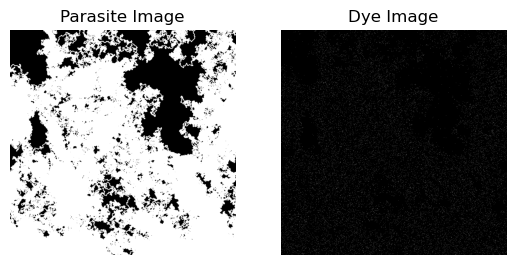

In [70]:
start_time = time.time() 

image_size = (1000, 1000)  # Define your image size
processor = ImageProcessor(image_size)

# Generate parasite and dye images
parasite_image, dye_image = processor.create_parasite_and_dye_images()

# Store both images using RLE
rle_encoded_parasite, rle_encoded_dye = processor.store_images_with_rle()

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken to generate and compress the images: {elapsed_time:.2f} seconds")

# Display the images
processor.display_images()


Time taken to decompress the images: 0.68 seconds


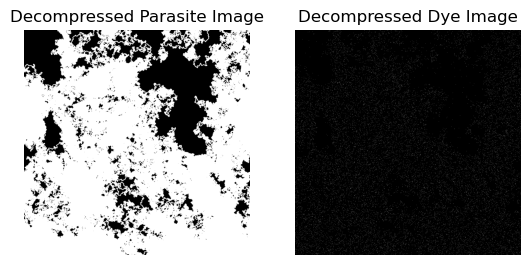

In [71]:
# Decompress RLE-encoded images
start_time = time.time() 

decompressed_parasite, decompressed_dye = processor.decompress_images(rle_encoded_parasite, rle_encoded_dye)

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken to decompress the images: {elapsed_time:.2f} seconds")

# Display the decompressed images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(decompressed_parasite, cmap='gray')
plt.title('Decompressed Parasite Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(decompressed_dye, cmap='gray')
plt.title('Decompressed Dye Image')
plt.axis('off')

plt.show()


In [72]:
# Calculate image sizes
raw_image_size, compressed_image_size = processor.calculate_image_size(rle_encoded_parasite, rle_encoded_dye)

# You can also calculate the sizes of the RLE-encoded images
rle_encoded_parasite_size = len(rle_encoded_parasite)
rle_encoded_dye_size = len(rle_encoded_dye)

# Print the sizes
print(f"Parasite and Dye combined Raw Image Size: {raw_image_size} bytes")
print(f"Parasite and Dye combined Compressed Image Size: {compressed_image_size} bytes")

# Print the sizes of RLE-encoded images
print(f"RLE-Encoded Parasite Size: {rle_encoded_parasite_size} units")
print(f"RLE-Encoded Dye Size: {rle_encoded_dye_size} units")


Parasite and Dye combined Raw Image Size: 2000000 bytes
Parasite and Dye combined Compressed Image Size: 275980 bytes
RLE-Encoded Parasite Size: 36207 units
RLE-Encoded Dye Size: 32788 units


This Compression rate is based on the 1000,1000 resolution image. For a 100000, 100000 resolution image the compression rate will be higher 

In [76]:
# Calculate the compression rate for both the parasite and the dye images combined
compression_rate = ((raw_image_size - compressed_image_size) / raw_image_size) * 100

print(f"Compression Rate: {compression_rate:.2f}%")


Compression Rate: 86.20%


3. 

In [74]:
def has_cancer(microscope_image, dye_image):
    # Calculate the area occupied by the parasite in the microscope image
    parasite_area_microscope = np.sum(microscope_image)

    # Calculate the area where both microscope and dye images have black pixels (overlap)
    overlap_area = np.sum(np.logical_and(microscope_image, dye_image))

    # Calculate the percentage of overlap relative to the parasite area in the microscope image
    overlap_percentage = (overlap_area / parasite_area_microscope) * 100

    # Check if the overlap percentage exceeds 10%
    if overlap_percentage > 10:
        return True  # The parasite has cancer in the overlap
    else:
        return False  # The parasite does not have cancer in the overlap


In [75]:
# Check if the parasite has cancer
result = has_cancer(parasite_image, dye_image)
print("Parasite has cancer:", result)

Parasite has cancer: False


4.

A faster approach could involve directly analyzing the RLE data of both the parasite and dye images to determine whether the parasite has cancer or not.

Another approach could be to use these simulated images to train a machine learning model for predicting the presence of cancer in the images.